# Least squares Fit

A couple of examples to show how to use:  
- scipy.optimize.minimize

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html 

(Minimization of scalar function of one or more variables. It can handle constraints)

See also:
https://matthew-brett.github.io/cfd2019/chapters/08/using_minimize

In [1]:
# from __future__ import print_function
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm, chi2

## Fit a gaussian
Consider a Gaussian. We are measuring some feature which has a Gaussian distribution in $x$. This could be an inhomogeneous spectral line for $x=E$ the energy of emitted photons. We are interested in the resonance frequency and the linewidth, i. e. we want to estimate them form our observations.

In [2]:
def gaussian_parent(x, mu, sigma):
    return norm.pdf(x, mu, sigma)    

def gaussian_sample(mu, sigma, sample_size):
    return norm.rvs(mu, sigma, sample_size)

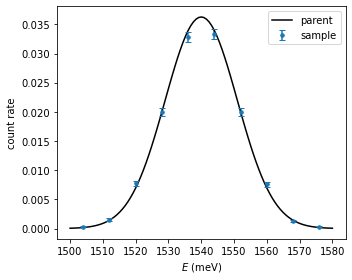

In [3]:
# Create sample
## SAMPLE SIZE
sample_size = 5000
##################

# Prepare toy data
mu = 1540  # True values that we will try to estimate
sigma = 11 # using a least-squares fit

x_arr = np.linspace(1500, 1580, 101)
bins = 10
sample = gaussian_sample(mu, sigma, sample_size)
hist = np.histogram(sample, bins=bins, range=(1500, 1580))
bin_width = np.diff(hist[1])[0]
normalization = bin_width * sample_size
x = hist[1][:-1]+bin_width/2
y = hist[0]/normalization
y_errors = np.sqrt( (np.sqrt(hist[0]) / normalization) **2) #sqrt(x^2) just to take the positive value

# Plot our toy measurement results
plt.figure(figsize=(5, 4))
plt.xlabel(r'$E$ (meV)')
plt.ylabel('count rate')
plt.plot(x_arr, gaussian_parent(x_arr, mu, sigma), '-', color='black', label='parent')
plt.errorbar(x, y, yerr=y_errors, fmt='.', ms=7, capsize=3, label='sample')
plt.legend()
plt.tight_layout()

# Save data
data = np.vstack((x, y, y_errors))
np.savetxt('data', data)
np.savetxt('sample', sample)

In [4]:
# Load data from disk. Format (x, y, y_error) x N 
data = np.loadtxt('data')
x = data[0, :]
y = data[1, :]
y_error = data[2, :]

In [5]:
# The function to be minimized.

# chi2 definition
def chi2(args):
    mu    = args[0]
    sigma = args[1]
    
    model = np.array([norm.pdf(e, mu, sigma) for e in x])

    chisq = np.sum(((y - model)/y_error)**2)
    return chisq

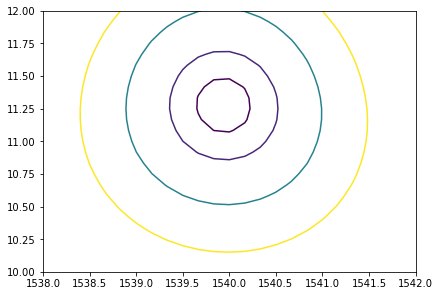

In [6]:
# scan of the 2D parameters space
scanMu    = np.linspace(1538.,1542.0,25)
scanSigma = np.linspace(10,12,25)
Z_binned =  [[chi2((a,b)) for a in scanMu] for b in scanSigma]
fig1, ax2 = plt.subplots(constrained_layout=True)

p2 = ax2.contour(scanMu, scanSigma, Z_binned, [10, 20, 50, 100])
plt.show()

In [7]:
# Perform the fit minimizing the least squares
res = minimize(chi2, [1545, 9])
err = np.sqrt(np.diag(res.hess_inv))
print('mu = {:1.4f} +- {:1.4f}'.format(res.x[0], err[0]))
print('sigma = {:1.4f} +- {:1.4f}'.format(res.x[1], err[1]))
print (res)

mu = 1539.9398 +- 0.1130
sigma = 11.2781 +- 0.0808
      fun: 6.6006946596971146
 hess_inv: array([[ 0.01276412, -0.00024784],
       [-0.00024784,  0.00652613]])
      jac: array([-4.76837158e-07,  3.03983688e-06])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 10
     njev: 12
   status: 0
  success: True
        x: array([1539.9398246 ,   11.27809987])


Compare with the parameters scan 

### Plot the result

In [8]:
def model_function(x, args):
    mu, sigma = args[0:2]
    return norm.pdf(x, mu, sigma)

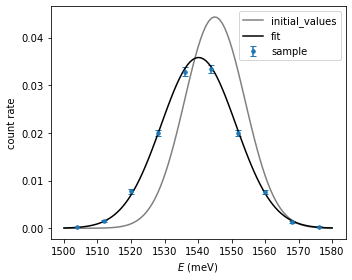

In [9]:
x_arr = np.linspace(1500, 1580, 101)

plt.figure(figsize=(5, 4))
plt.xlabel(r'$E$ (meV)')
plt.ylabel('count rate')
plt.errorbar(x, y, yerr=y_error, fmt='.', ms=7, capsize=3, label='sample')
plt.plot(x_arr, model_function(x_arr,[1545, 9]), '-', color='grey', label='initial_values')
plt.plot(x_arr, model_function(x_arr,[1540.1525, 11.1390]), '-', color='black', label='fit')
plt.legend()
plt.tight_layout()

What happens if you reduce significantly the number of events or increase the number of bins ? (mind empty bins!)